# Storage Solutions for Big Data - CA1


The assessment CA 1 by **Yulianna Tsaruk** \
Programme Title: Higher Diploma in Science in AI Applications \
Module Title: Storage Solutions for Big Data



## Code contents:
1. **Exploratory Data Analysis & Processing (this file)**
2. **[Training model and Usage Example](./2_training.ipynb)**



## Intoduction

For this project I'm using HDFS (Hadoop Distributed File System) as the primary storage system, Apache Spark for processing with PySpark - an interface for Apache Spark in Python.

In this file, I will load several files from a selected dataset, process them and store them in Apache Parquet - a highly efficient column-oriented data storage format in the Apache Hadoop ecosystem.

## Preparation

In [1]:
# import spark instances
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import to_date, dayofmonth, month, year, col, explode, \
                unix_timestamp, when, regexp_replace, mean, concat_ws, \
                dayofweek, udf, min, max, desc, count
from pyspark.sql.types import FloatType, BooleanType, StringType

# import additional libraries
import pandas as pd
import matplotlib.pyplot as plt
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

try:
    import holidays
except ImportError:
    # install library
    !pip install holidays

In [2]:
# Creating Spark session with configurations
spark = (SparkSession.builder \
    .appName("Tokyo Airbnb Processing and Analysis")
    # hardware-related configs, comment it if not needed for your machine.
    .config("spark.driver.memory", "6g")
    .config("spark.executor.memory", "6g")  
    .config("spark.dynamicAllocation.enabled", "true")
    .config("spark.network.timeout", "600s") 
    .config("spark.executor.heartbeatInterval", "120s")
    
    # to output more
    .config("spark.sql.debug.maxToStringFields", 100)
    .getOrCreate())

24/04/26 00:16:33 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
# simulating same output equivalent to the pandas.DataFrame.info() method  
def print_dataframe_info(df: DataFrame):
    """
    Print basic information about data like column names, null counts, and data types for a Spark DataFrame.

    Args:
    df (DataFrame): The Spark DataFrame to be analyze.
    """
    # DataFrame shape
    total_rows = df.count()
    total_cols = len(df.columns)
    

    # Collect column names and their data types
    schema_info = [(field.name, field.dataType) for field in df.schema.fields]
    out_ = []
    for column, dtype in schema_info:
        null_count = df.filter(col(column).isNull()).count()
        out_.append({'Column': column, 'Nulls': null_count, 'Type': dtype.simpleString()})
    
    print(pd.DataFrame(out_))
    print()
    print(f"\tA dataset shape: {total_rows} rows, {total_cols} columns.")

pd.set_option('display.max_rows', None) # show all rows for pandas df
pd.set_option('display.float_format', lambda x: '%.3f' % x) # avoid scientific notation

## Load 1st dataset

In [89]:
# Set path to folder with dataset on HDFS
dataset_path_hdfs = '/user1/dataset/' # musr end with /

In [4]:
# location of 1st file in Hadoop
dataset_path = dataset_path_hdfs + "calendar.csv" 

# load data
df_calendar = spark.read.csv(dataset_path, header=True, # 1st line is a header
                             inferSchema=True           # detect data types automatically
                            )
df_calendar.show(5)

+----------+----------+---------+----------+--------------+--------------+--------------+
|listing_id|      date|available|     price|adjusted_price|minimum_nights|maximum_nights|
+----------+----------+---------+----------+--------------+--------------+--------------+
|    197677|2023-06-29|        f|$11,000.00|    $11,000.00|             3|          1125|
|    197677|2023-06-30|        f|$11,000.00|    $11,000.00|             3|          1125|
|    197677|2023-07-01|        f|$11,000.00|    $11,000.00|             3|          1125|
|    197677|2023-07-02|        f|$11,000.00|    $11,000.00|             3|          1125|
|    197677|2023-07-03|        f|$11,000.00|    $11,000.00|             3|          1125|
+----------+----------+---------+----------+--------------+--------------+--------------+
only showing top 5 rows



### Explore and Process the data

In [5]:
# Nulls and types summary
print_dataframe_info(df_calendar)

           Column  Nulls    Type
0      listing_id      0  bigint
1            date      0    date
2       available      0  string
3           price      0  string
4  adjusted_price      0  string
5  minimum_nights    332     int
6  maximum_nights    332     int

	A dataset shape: 4078413 rows, 7 columns.


In [6]:
# Statistical summary
df_calendar.describe().show()

+-------+--------------------+---------+-------------+--------------+------------------+------------------+
|summary|          listing_id|available|        price|adjusted_price|    minimum_nights|    maximum_nights|
+-------+--------------------+---------+-------------+--------------+------------------+------------------+
|  count|             4078413|  4078413|      4078413|       4078413|           4078081|           4078081|
|   mean|2.520073870723633...|     null|         null|          null|2.7664423536462373| 676.3645109059873|
| stddev|3.745944660493916...|     null|         null|          null|12.338796688561727|449.44182861714916|
|    min|              197677|        f|$1,000,000.00| $1,000,000.00|                 1|                 1|
|    max|  923132709196905769|        t|  $999,999.00|   $999,999.00|              1000|              1125|
+-------+--------------------+---------+-------------+--------------+------------------+------------------+



Some variables are wrong dtype. For example, we can't see mean of price column, because values are string type. 

In [7]:
# Check amount of unique values in the 'listing_id' column
listing_gr = df_calendar.groupBy("listing_id").count()
unique_ids = listing_gr.count()
print('There are', listing_gr.count(), 'properties in this dataset.')

pandas_df_listing = listing_gr.orderBy(col("count")).toPandas()
pandas_df_listing['days_count'] = pandas_df_listing['count']
result = pandas_df_listing.groupby('days_count').size().reset_index(name='properties_count')
pandas_df_listing.head()

There are 11175 properties in this dataset.


,listing_id,count,days_count
0,4050925,33,33
1,12597472,339,339
2,19413667,339,339
3,742241466430561437,339,339
4,806171362910072416,339,339


In [8]:
result

,days_count,properties_count
0,33,1
1,339,5
2,365,11169


In [9]:
listing_to_drop = list(pandas_df_listing[pandas_df_listing['count'] <= 339]['listing_id'])
listing_to_drop

[4050925,
 12597472,
 19413667,
 742241466430561437,
 806171362910072416,
 772140258073141388]

In [10]:
df_calendar.filter(col("listing_id").isin(listing_to_drop)).count()

1728

1 property has data only for 33 days, while most of other properties obtain data for a whole year (365 days). I will drop this property and other 5 that has data only for 339 days, as it's only rows.

In [11]:
# drop rows for ids because too much data is missing
df_calendar_clean = df_calendar.filter(~col("listing_id").isin(listing_to_drop))


In [12]:
print_dataframe_info(df_calendar)

           Column  Nulls    Type
0      listing_id      0  bigint
1            date      0    date
2       available      0  string
3           price      0  string
4  adjusted_price      0  string
5  minimum_nights    332     int
6  maximum_nights    332     int

	A dataset shape: 4078413 rows, 7 columns.


In [13]:
# Options in col 'available'
df_calendar_clean.select('available').distinct().show()

+---------+
|available|
+---------+
|        f|
|        t|
+---------+



It's worth to note that, though price has a US dollar sign, it is in Japanese Yen and a sign must be removed in order to convert data to float.

In [14]:
# check min/max nights values
nights_df = df_calendar_clean.select(col('minimum_nights'), col('maximum_nights')).toPandas()
nights_df.describe()

,minimum_nights,maximum_nights
count,4076353.000,4076353.000
mean,2.767,676.305
std,12.341,449.516
min,1.000,1.000
25%,1.000,365.000
50%,2.000,365.000
75%,2.000,1125.000
max,1000.000,1125.000


In [15]:
nights_df.head()

,minimum_nights,maximum_nights
0,3.000,1125.000
1,3.000,1125.000
2,3.000,1125.000
3,3.000,1125.000
4,3.000,1125.000


In [16]:
# nights_df.plot(kind='density')

In [17]:
# Data Preprocessing
df_calendar_new = df_calendar \
    .withColumn("available", when(col("available") == "t", 1).otherwise(0)) \
    .withColumn("price", regexp_replace(col("price"), "[\$,]", "").cast(FloatType())) \
    .withColumn("adjusted_price", regexp_replace(col("adjusted_price"), "[\$,]", "").cast(FloatType())) \
    .withColumn("date_unix", unix_timestamp(col("date")))

In [18]:
# check price col
df_calendar_new.select(col('price')).describe().toPandas()

,summary,price
0,count,4078413
1,mean,36832.33714314857
2,stddev,97990.26909538891
3,min,1350.0
4,max,9999999.0


In [19]:
price_data = df_calendar_new.select('price').toPandas()

In [20]:
price_dist = price_data.groupby('price').size().reset_index(name='count').sort_values('price')

<AxesSubplot:title={'center':'Distribution of values in column "price"'}, xlabel='price', ylabel='count'>

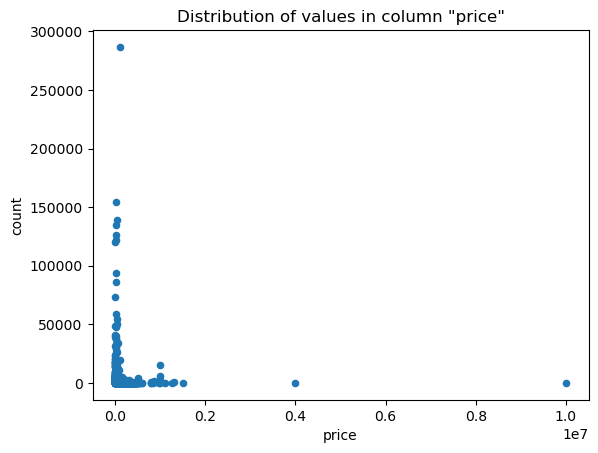

In [21]:
price_dist.plot(kind='scatter', x='price', y='count', 
                legend=False, title='Distribution of values in column "price"')

In [22]:
# Find out if there's a difference in cols "price" and "adjusted_price"
df_with_diff = df_calendar_new.withColumn("price_difference", col("price") - col("adjusted_price"))

# Filter rows where price_difference is not zero
rows_with_difference = df_with_diff.filter(col("price_difference") != 0)

# count how many rows with differences
rows_with_difference.count()

465529

In [23]:
rows_with_difference.filter(col('adjusted_price')>col('price')).count()

25639

In [24]:
rows_with_difference.filter(col('adjusted_price')<col('price')).count()

439890

In [25]:
df_calendar_new.filter(col('adjusted_price')==col('price')).count()

3612884

Since there's no data dictionary, I don't really know for sure what is 'adjusted_price' col, but I will take it as main and save col 'price' to drop later.

In [26]:
# alongside with 'min/maximum_nights' which doesn't look correct
col_to_drop = ['price', 'minimum_nights', 'maximum_nights']

In [27]:
# clear unused df-s from memory
df_with_diff.unpersist()
rows_with_difference.unpersist()

DataFrame[listing_id: bigint, date: date, available: int, price: float, adjusted_price: float, minimum_nights: int, maximum_nights: int, date_unix: bigint, price_difference: float]

## Load 2nd dataset

In [28]:
df_list = spark.read.csv(dataset_path_hdfs + "listings.csv",
    header=True, # 1st line is a header
    quote='"',  
    escape='"', 
    multiLine=True,  # Handles new lines in fields
    inferSchema=True,  # detect data types automatically
    ignoreLeadingWhiteSpace=True,  # Ignoring white space in a line
    ignoreTrailingWhiteSpace=True)

In [29]:
df_list.show(2)

+------+--------------------+--------------+------------+-----------+--------------------+--------------------+---------------------+--------------------+-------+--------------------+---------------+----------+-------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+--------+---------+--------------------+---------------+------------+---------+--------------+--------+----+--------------------+----------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+----------------+---------------------+------

In [30]:
# The output above is messy, let's print it pandas' df
df_list.limit(5).toPandas()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,197677,https://www.airbnb.com/rooms/197677,20230629055629,2023-06-29,city scrape,Rental unit in Sumida · ★4.78 · 1 bedroom · 2 ...,<b>The space</b><br />We are happy to welcome ...,None,https://a0.muscache.com/pictures/38437056/d27f...,964081,...,4.830,4.530,4.790,M130003350,f,1,1,0,0,1.210
1,776070,https://www.airbnb.com/rooms/776070,20230629055629,2023-06-29,city scrape,Home in Kita-ku · ★4.98 · 1 bedroom · 1 bed · ...,We have been in airbnb since 2011 and it has g...,We love Nishinippori because is nearer to Toky...,https://a0.muscache.com/pictures/efd9f039-dbd2...,801494,...,4.980,4.830,4.910,None,f,1,0,1,0,1.890
2,905944,https://www.airbnb.com/rooms/905944,20230629055629,2023-06-29,city scrape,Rental unit in Shibuya · ★4.76 · 2 bedrooms · ...,NEWLY RENOVATED property entirely for you & yo...,Hatagaya is a great neighborhood located 4 min...,https://a0.muscache.com/pictures/miso/Hosting-...,4847803,...,4.900,4.770,4.770,Hotels and Inns Business Act | 渋谷区保健所長 | 31渋健生...,t,5,5,0,0,1.490
3,1016831,https://www.airbnb.com/rooms/1016831,20230629055629,2023-06-29,city scrape,Home in Setagaya · ★4.94 · 1 bedroom · 2 beds ...,"Hi there, I am Wakana and I live with my two f...",The location is walkable distance to famous Sh...,https://a0.muscache.com/pictures/airflow/Hosti...,5596383,...,4.980,4.920,4.890,None,f,1,0,1,0,1.960
4,1196177,https://www.airbnb.com/rooms/1196177,20230629055629,2023-06-29,city scrape,Home in 足立区 · ★4.71 · 1 bedroom · 1.5 shared b...,Ｓtay with host.We can help your travel.<br />B...,There are shopping mall near Senjuohashi stati...,https://a0.muscache.com/pictures/72890882/05ec...,5686404,...,4.880,4.670,4.750,None,f,1,0,1,0,0.790


In [31]:
# check if everithing loaded correctly through schema
df_list.printSchema()

root
 |-- id: long (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: long (nullable = true)
 |-- last_scraped: date (nullable = true)
 |-- source: string (nullable = true)
 |-- name: string (nullable = true)
 |-- description: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: date (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_about: string (nullable = true)
 |-- host_response_time: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_acceptance_rate: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_thumbnail_url: string (nullable = true)
 |-- host_picture_url: string (nullable = true)
 |-- host_neighbourhood: string (nullable = true)
 |-- host_listings_count: int

From this dataset I'll take some info to complete my 1st one. Potentially useful columns are:
* neighbourhood_cleansed
* host_identity_verified
* property_type
* instant_bookable

In [32]:
df_list.select('property_type').distinct().toPandas()

,property_type
0,Entire chalet
1,Earthen home
2,Farm stay
3,Entire rental unit
4,Shared room in hostel
5,Private room in condo
6,Room in boutique hotel
7,Room in bed and breakfast
8,Hut
9,Entire cabin


In [33]:
df_list.select('room_type').distinct().toPandas()

,room_type
0,Shared room
1,Hotel room
2,Entire home/apt
3,Private room


After checking unique values, I see that the feature I want is called 'room_type', while 'property_type' consist of marketing names.

In [34]:
print_dataframe_info(df_list)

                                          Column  Nulls    Type
0                                             id      0  bigint
1                                    listing_url      0  string
2                                      scrape_id      0  bigint
3                                   last_scraped      0    date
4                                         source      0  string
5                                           name      0  string
6                                    description      1  string
7                          neighborhood_overview   3456  string
8                                    picture_url      0  string
9                                        host_id      0     int
10                                      host_url      0  string
11                                     host_name      0  string
12                                    host_since      0    date
13                                 host_location   3582  string
14                                    ho

In [35]:
# check unique values in the 'id' column
unique_ids_list = df_list.select("id").distinct()

print(f'Unique IDs: {unique_ids_list.count()},', unique_ids_list.count()-unique_ids, 'properties more than in calendar data.')

Unique IDs: 11177, 2 properties more than in calendar data.


In [36]:
# select columns that I want to use to expand calendar df
selected_cols = [
    'id',
    'neighbourhood_cleansed',
    'room_type',
    'host_identity_verified',
    'instant_bookable',
]
new_df = df_list.select(selected_cols)
# Merge new df with selected_cols and df_calendar on col id and listing_id
merged_df = new_df.join(df_calendar_new, new_df.id == df_calendar_new.listing_id, "inner")

In [37]:
merged_df.take(1)

[Row(id=197677, neighbourhood_cleansed='Sumida Ku', room_type='Entire home/apt', host_identity_verified='t', instant_bookable='f', listing_id=197677, date=datetime.date(2023, 6, 29), available=0, price=11000.0, adjusted_price=11000.0, minimum_nights=3, maximum_nights=1125, date_unix=1687996800)]

In [38]:
merged_df = merged_df.drop('listing_id') # dublicated col

In [39]:
#fixing dtypes
df = merged_df \
    .withColumn("host_identity_verified", when(col("host_identity_verified") == "t", True).otherwise(False).cast(BooleanType())) \
    .withColumn("instant_bookable", when(col("instant_bookable") == "t", True).otherwise(False).cast(BooleanType()))

merged_df.unpersist()
new_df.unpersist()

In [40]:
df.dtypes

[('id', 'bigint'),
 ('neighbourhood_cleansed', 'string'),
 ('room_type', 'string'),
 ('host_identity_verified', 'boolean'),
 ('instant_bookable', 'boolean'),
 ('date', 'date'),
 ('available', 'int'),
 ('price', 'float'),
 ('adjusted_price', 'float'),
 ('minimum_nights', 'int'),
 ('maximum_nights', 'int'),
 ('date_unix', 'bigint')]

## Analysis

In [51]:
df_busy_times = df.where(col("available") == False)\
                  .withColumn("year_month", concat_ws("-", year("date"), month("date"))) \
                  .select('year_month') \
                  .groupBy("year_month").count().toPandas()

df_busy_times['year_month'] = df_busy_times['year_month'].astype('period[M]')
df_busy_times.sort_values(['year_month'], ascending=True, inplace=True)

In [52]:
df_busy_times.head()

,year_month,count
0,2023-12,172760
1,2024-06,237767
2,2023-11,152969
3,2024-04,263468
4,2023-09,127688


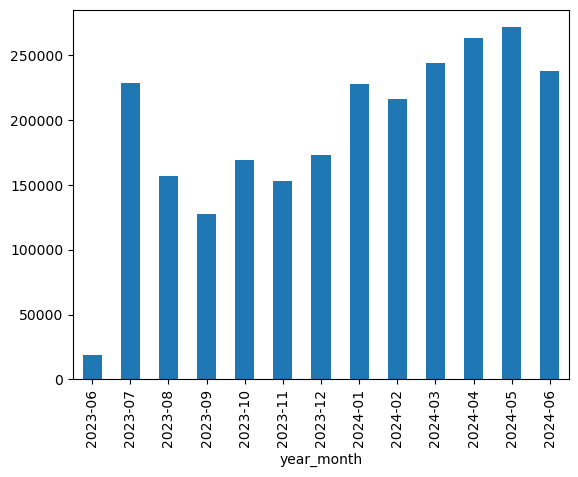

In [88]:
ax=df_busy_times.plot(x='year_month', y='count', kind='bar', legend=False)
#ax.bar_label(ax.containers[0])

In [62]:
#'month+year' column, calculate the mean of 'price',
# and sort the results by 'year-month

df_price = df.where(col("price") > 0) \
                  .withColumn("year_month", concat_ws("-", year("date"), month("date"))) \
                  .groupBy("year_month") \
                  .agg(mean("price").alias("mean")) \
                  .toPandas()

df_price['year_month'] = df_price['year_month'].astype('period[M]')
df_price.sort_values('year_month', ascending=True, inplace=True)

In [63]:
df_price.head()

,year_month,mean
10,2023-06,24948.570
11,2023-07,26837.515
8,2023-08,28268.562
4,2023-09,33886.480
7,2023-10,34420.471


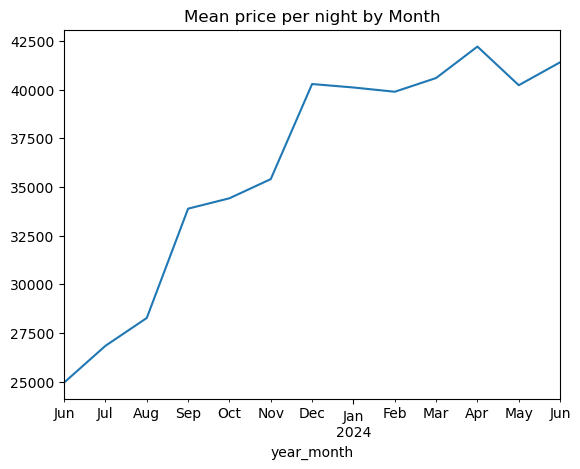

In [72]:
ax = df_price.plot(kind='line', 
                   x='year_month', y='mean', 
                   legend=False,
                  title="Mean price per night by Month")

In [ ]:
df_list.unpersist()

In [ ]:
df_calendar.unpersist()

## Feature Selection and Engineering

In [73]:
df.columns

['id',
 'neighbourhood_cleansed',
 'room_type',
 'host_identity_verified',
 'instant_bookable',
 'date',
 'available',
 'price',
 'adjusted_price',
 'minimum_nights',
 'maximum_nights',
 'date_unix']

I'd like to add new features regarding date to help algorithm find dependencies:
- if date is a weekend
- if date is a holiday

In [74]:
# if date is a weekend
df_date = df.withColumn("weekends", dayofweek(col("date")).isin([6, 7]))

In [76]:
# for holiday detection I use holidays module and user-defined function
jp_holidays = holidays.Japan()

def is_holiday(date):
    return date in jp_holidays

holiday_udf = udf(is_holiday, BooleanType())

df_date = df_date.withColumn("holiday", holiday_udf(col("date"))).sort('date')

In [77]:
print_dataframe_info(df_date)

                    Column  Nulls     Type
0                       id      0   bigint
1   neighbourhood_cleansed      0   string
2                room_type      0   string
3   host_identity_verified      0  boolean
4         instant_bookable      0  boolean
5                     date      0     date
6                available      0      int
7                    price      0    float
8           adjusted_price      0    float
9           minimum_nights    332      int
10          maximum_nights    332      int
11               date_unix      0   bigint
12                weekends      0  boolean
13                 holiday      0  boolean

	A dataset shape: 4078413 rows, 14 columns.


In [78]:
col_to_drop += ['id', 'date']
col_to_drop

['price',
 'minimum_nights',
 'maximum_nights',
 'id',
 'minimum_nights',
 'maximum_nights',
 'date']

In [79]:
# Cleaning up 
# deleting cols that won't be used for training
df_model = df_date.drop(*col_to_drop)
# rename col
df_model = df_model.withColumnRenamed('adjusted_price', 'price')

In [80]:
# Save DataFrame to HDFS in Parquet format
df_model.write.parquet(dataset_path_hdfs +"db",
                       # for re-running this code
                       mode="overwrite")

In [81]:
spark.stop()